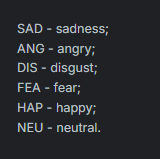

# Resourses
- https://www.kaggle.com/code/dmitrybabko/speech-emotion-recognition-conv1d
- https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition
- https://librosa.org/doc/latest/index.html
- https://www.kaggle.com/code/hossamemamo/speech-emotion-recognition-2-parallel-cnn-conv-2d
- https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition
- 

In [ ]:


import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Optional: reduce TF logging

import tensorflow as tf

# GPU Memory Growth Setup — MUST BE BEFORE ANY OTHER TF/KERAS CALL
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU detected and memory growth set:", gpus)
    except RuntimeError as e:
        print("⚠️ Could not set memory growth:", e)
else:
    print("❌ No GPU detected. Using CPU.")

# ✅ NOW safe to import the rest
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from IPython.display import Audio
import torch
from sklearn.preprocessing import OneHotEncoder




In [ ]:
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
# Paths to
Ravdess = "../input/speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24"
Crema = "../input/speech-emotion-recognition-en/Crema"
Savee = "../input/speech-emotion-recognition-en/Savee"
Tess = "../input/speech-emotion-recognition-en/Tess"
print(os.listdir(Ravdess))

In [ ]:
emotion_df = []

for wav in os.listdir(Crema):
    info = wav.partition(".wav")[0].split("_")
    if info[2] == 'SAD':
        emotion_df.append(("sad", Crema + "/" + wav))
    elif info[2] == 'ANG':
        emotion_df.append(("angry", Crema + "/" + wav))
    elif info[2] == 'DIS':
        emotion_df.append(("disgust", Crema + "/" + wav))
    elif info[2] == 'FEA':
        emotion_df.append(("fear", Crema + "/" + wav))
    elif info[2] == 'HAP':
        emotion_df.append(("happy", Crema + "/" + wav))
    elif info[2] == 'NEU':
        emotion_df.append(("neutral", Crema + "/" + wav))
    else:
        emotion_df.append(("unknown", Crema + "/" + wav))


Crema_df = pd.DataFrame.from_dict(emotion_df)
Crema_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Crema_df.head()

In [ ]:
# df = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis=0)
df = pd.concat([Crema_df], axis=0)
df.shape

In [ ]:
%matplotlib inline

plt.style.use("ggplot")

In [ ]:
plt.title("Count of emotions:")
sns.countplot(x=df["Emotion"])
sns.despine(top=True, right=True, left=False, bottom=False)

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [ ]:
emotion='fear'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
emotion='angry'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
emotion='sad'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data augmentation

We have some ways for data augmentation in sound data:

1. Noise injection
2. Stretching
3. Shifting
4. Pitching

In [ ]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    """Stretching data with some rate."""
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data, rate=1000):
    """Shifting data with some rate"""
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7, random=False):
    """"Add some pitch to sound sample. Use random if you want to add random pitch with some threshold.
    Or use pitch_factor Random=False and rate for always adding fixed pitch."""
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

In [ ]:
df.head()

## 2D

In [ ]:
n_fft = 2048
hop_length = 512

In [ ]:
import torchaudio
import torchaudio.transforms as transforms
from tqdm import tqdm

S_dB_Total = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for idx, path in tqdm(enumerate(df.Path)):
    waveform, sample_rate = torchaudio.load(path)

    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    
    # Convert to tensor
    waveform = torch.tensor(waveform).to(device)

    # Convert to mel spectrogram
    mel_transform = transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=2048,
        hop_length=512,
        n_mels=128
    ).to(device)
    
    S = mel_transform(waveform)

    # Convert to dB
    power_to_db = transforms.AmplitudeToDB()
    S_dB = power_to_db(S)

    S_dB_Total.append(S_dB.squeeze())

In [ ]:
sizes=[]
for x in S_dB_Total:
    sizes.append(x.shape[1])

In [ ]:
# Calculate the bin counts
bincount_array = np.histogram(sizes, bins=np.arange(min(sizes), max(sizes)+2))[0]

# Create a list of labels for the x-axis
x_labels = np.arange(min(sizes), max(sizes)+1)

# Plot the bin counts as a bar plot
plt.bar(x_labels, bincount_array)

# Set labels and title
plt.xlabel('Numbers')
plt.ylabel('Count')
plt.show()

print(f'min is {min(sizes)}')
print(f'max is {max(sizes)}')

In [ ]:
import numpy as np
padding_length = 160
padded_list = []
for array in S_dB_Total:
    current_shape = array.cpu().shape
    padding = [(0, 0), (0, padding_length - current_shape[1])]
    padded_array = np.pad(array.cpu(), padding, mode='constant', constant_values=0)
    padded_list.append(padded_array)

# Convert the padded list to a NumPy array
data_2D = np.array(padded_list)
    

In [ ]:
data_2D.shape

In [ ]:
df.Emotion.unique()


In [ ]:
df.Emotion.head()

In [ ]:
#normalization
from sklearn.preprocessing import MinMaxScaler

# Reshape the array to 2D
reshaped_data = data_2D.reshape((-1, 1))

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
normalized_data = scaler.fit_transform(reshaped_data)

# Reshape the normalized data back to the original shape
normalized_data = normalized_data.reshape(data_2D.shape)

In [ ]:
normalized_data[1]

In [ ]:
data=np.expand_dims(normalized_data, axis=1)

In [ ]:
labels=df.Emotion.replace({'disgust': 1, 'happy': 2, 'sad': 3, 'neutral': 4, 'fear': 5, 'angry': 6}).to_numpy()

In [ ]:
labels.shape

In [ ]:
np.unique(labels)

In [ ]:
data.shape

In [ ]:
# torch.save({
#     'data': torch.tensor(data_2D),  
#     'labels': torch.tensor(labels) 
# }, 'dataset.pt')


In [ ]:
data = np.transpose(data, (0, 2, 3, 1))


In [ ]:
data.shape

In [ ]:
labels.shape

## Final Size

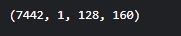
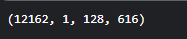

## Data Split

In [ ]:
# 1) Split raw data & labels
#    “data” here must be shape (N, 1, 128, 160)
#    “labels” is shape (N,)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    data, labels, test_size=0.3, stratify=labels, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.05, stratify=y_trainval, random_state=42
)

# 2) One‑hot encode labels
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
y_train = enc.fit_transform(y_train.reshape(-1, 1))
y_val   = enc.transform   (y_val  .reshape(-1, 1))
y_test  = enc.transform   (y_test .reshape(-1, 1))

# 3) Scale pixel values per‑pixel
ns, _, _, _ = X_train.shape
h, w, c    = 128, 160, 1  # known spectrogram dims
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train.reshape(-1, h*w*c))
X_val   = scaler.transform   (X_val  .reshape(-1, h*w*c))
X_test  = scaler.transform   (X_test .reshape(-1, h*w*c))

X_train = X_train.reshape(ns, h, w, c)
X_val   = X_val.reshape(-1, h, w, c)
X_test  = X_test.reshape(-1, h, w, c)

# 4) TRANSPOSE ONCE: bring channels last
# X_train = np.transpose(X_train, (0, 1, 2, 3))  # already (N,128,160,1), placeholder
# X_val   = np.transpose(X_val,   (0, 1, 2, 3))
# X_test  = np.transpose(X_test,  (0, 1, 2, 3))

# (If your original data came in (N,1,128,160), use:)
# X_train = np.transpose(X_train, (0, 2, 3, 1))
# X_val   = np.transpose(X_val,   (0, 2, 3, 1))
# X_test  = np.transpose(X_test,  (0, 2, 3, 1))



# 5) Build tf.data.Dataset pipelines
train_dataset = (
    tf.data.Dataset
      .from_tensor_slices((X_train, y_train))
      .shuffle(2000)
      .batch(64)
      .prefetch(tf.data.AUTOTUNE)
)
val_dataset = (
    tf.data.Dataset
      .from_tensor_slices((X_val, y_val))
      .batch(64)
      .prefetch(tf.data.AUTOTUNE)
)
test_dataset = (
    tf.data.Dataset
      .from_tensor_slices((X_test, y_test))
      .batch(64)
      .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
print(data.shape)    # Should be (7442, ...)
print(labels.shape)  # Should be (7442,) or (7442, 1)


In [ ]:

batch = next(iter(train_dataset))

# Unpack inputs and labels
inputs, labels = batch

# Print shapes
print("Inputs shape:", inputs.shape)
print("Labels shape:", labels.shape)

# Model

In [ ]:
def cnn_2d_model(input_shape, num_classes, filters, kernels):
    model = models.Sequential([
        layers.Conv2D(filters[0], kernel_size=kernels[0], strides=1, padding='same', activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 5), strides=(2, 2), padding='same'),

        layers.Conv2D(filters[0], kernel_size=kernels[0], strides=1, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 5), strides=(2, 2), padding='same'),

        layers.Conv2D(filters[1], kernel_size=kernels[1], strides=1, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 5), strides=(2, 2), padding='same'),

        layers.Conv2D(filters[2], kernel_size=kernels[2], strides=1, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 3), strides=(2, 2), padding='same'),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
filter_sets_2d = [
    (128, 128, 64, 64, 32),
    (512, 256, 256, 128, 64),
    (512, 512, 512, 256, 128)
]


kernel_sets_2d = [
    [(1,3), (3,5), (3,5), (3,3), (3,3)],
    [(3,5), (3,5), (3,5), (3,3), (3,3)],
    [(5,5), (5,5), (3,5), (3,3), (1,3)]
]

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("✅ GPU detected:", gpus)
else:
    print("❌ No GPU detected. Using CPU.")

input_shape_2d = X_train.shape[1:] 
results_2d = []
num_classes = 6

for filters in filter_sets_2d:
    for kernels in kernel_sets_2d:
        print(f"\nTraining 2D CNN: filters={filters}, kernels={kernels}")
        
        model_2d = cnn_2d_model(input_shape_2d, num_classes, filters, kernels)
        
        history_2d = model_2d.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=200,
            callbacks=[early_stop],
            verbose=0
        )

        y_pred_2d = model_2d.predict(val_dataset)
        y_pred_classes_2d = np.argmax(y_pred_2d, axis=1)

        y_true_classes_2d = np.concatenate(
    [np.argmax(y, axis=1) for _, y in val_dataset.as_numpy_iterator()], axis=0)

        val_acc_2d = max(history_2d.history['val_accuracy'])
        f1_2d = f1_score(y_true_classes_2d, y_pred_classes_2d, average='weighted')

        print(f"→ Val Acc (2D): {val_acc_2d:.4f} | F1 Score (2D): {f1_2d:.4f} | Filters: {filters} | Kernels: {kernels}")
        results_2d.append(((filters, kernels), val_acc_2d, f1_2d))

In [ ]:
full_dataset = (
    tf.data.Dataset
      .from_tensor_slices((np.concatenate([X_train, X_val], axis=0),
                           np.concatenate([y_train, y_val], axis=0)))
      .shuffle(2000)
      .batch(64)
)


In [ ]:
early_stop = EarlyStopping(
    monitor='accuracy',        # or 'accuracy' if preferred
    patience=10,
    restore_best_weights=True
)


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("✅ GPU detected:", gpus)
else:
    print("❌ No GPU detected. Using CPU.")

# Model setup and training
best_filters = (128, 128, 64, 64, 32)
best_kernels = [(1, 3), (3, 5), (3, 5), (3, 3), (3, 3)]
final_model = cnn_2d_model(input_shape_2d, num_classes, best_filters, best_kernels)

history = final_model.fit(
    full_dataset,
    epochs=250,
    callbacks=[early_stop],
    verbose=1
)

In [ ]:
final_train_acc = history.history['accuracy'][-1]
print(f"Final Train Accuracy: {final_train_acc:.4f}")

In [ ]:
# 6) Get predictions and compute F1 manually
y_pred_probs = final_model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Build true labels from test_dataset
y_true_classes = np.concatenate([np.argmax(y, axis=1) for _, y in test_dataset], axis=0)

test_f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
test_acc = accuracy_score(y_true_classes, y_pred_classes)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

In [ ]:
labels_dict = {'disgust': 1, 'happy': 2, 'sad': 3, 'neutral': 4, 'fear': 5, 'angry': 6}

# Sort the keys based on their mapped values (1 to 6)
class_names = [k for k, v in sorted(labels_dict.items(), key=lambda item: item[1])]

In [ ]:


cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Test Confusion Matrix")
plt.show()
